# PRISMA and EMIT readers

## Install package  dependecies 

EMIT requires the `netcdf4` package to read the products. We will also use the `pysolar` package to convert the EMIT L1B radiances to reflectances. PRISMA requires the `h5py` package and we need `scipy` for the `georeader.reflectance` module.

```
pip install netcdf4 pysolar h5py scipy
```

## Read images

In [1]:
import os
prisma_path = "prisma_database/PRS_L1_STD_OFFL_20230929102749_20230929102753_0001.he5"
emit_path = "emit_database/raw/EMIT_L1B_RAD_001_20230929T122534_2327208_039.nc"
os.path.exists(prisma_path),os.path.exists(emit_path)

(True, True)

In [2]:
from georeader.readers import emit
from georeader.readers import prisma
import matplotlib.pyplot as plt
from georeader import plot
from georeader import read
import matplotlib.pyplot as plt
from shapely.geometry import Point
from georeader.window_utils import polygon_to_crs

ei = emit.EMITImage(emit_path).to_crs()
ei

 
         File: emit_database/raw/EMIT_L1B_RAD_001_20230929T122534_2327208_039.nc
         Transform: | 60.00, 0.00, 184463.99|
| 0.00,-60.00, 3571041.85|
| 0.00, 0.00, 1.00|
         Shape: (285, 1935, 2004)
         Resolution: (60.0, 60.0)
         Bounds: (184463.98930973688, 3454941.8506227555, 304703.9893097369, 3571041.8506227555)
         CRS: EPSG:32632
         units: uW/cm^2/SR/nm
        

In [3]:
pi = prisma.PRISMA(prisma_path)
pi


        File: prisma_database/PRS_L1_STD_OFFL_20230929102749_20230929102753_0001.he5
        Bounds: (5.843493461608887, 31.288787841796875, 6.223865509033203, 31.612695693969727)
        Time: 2023-09-29 10:27:49.047000+00:00
        VNIR Range: (406.9934, 977.3654) 63 bands
        SWIR Range: (943.3579, 2497.1155) 171 bands
        

In [4]:
# Load SWIR and NIR PRISMA images
pi.load_raw(swir_flag=True)
_ = pi.load_raw(swir_flag=False)

## Read same pixel value

In [5]:
pixel_prisma = (45, 65)

# The raw values of prisma are col major
point_prisma = pi.lons[pixel_prisma[-1::-1]],pi.lats[pixel_prisma[-1::-1]]

ei_on_point = read.read_from_center_coords(ei, point_prisma, 
                                           shape=(50,50), 
                                           crs_center_coords="EPSG:4326").load()
ei_on_point

 
         Transform: | 60.00, 0.00, 207203.99|
| 0.00,-60.00, 3501321.85|
| 0.00, 0.00, 1.00|
         Shape: (285, 50, 50)
         Resolution: (60.0, 60.0)
         Bounds: (207203.98930973688, 3498321.8506227555, 210203.98930973688, 3501321.8506227555)
         CRS: EPSG:32632
         fill_value_default: 0
        

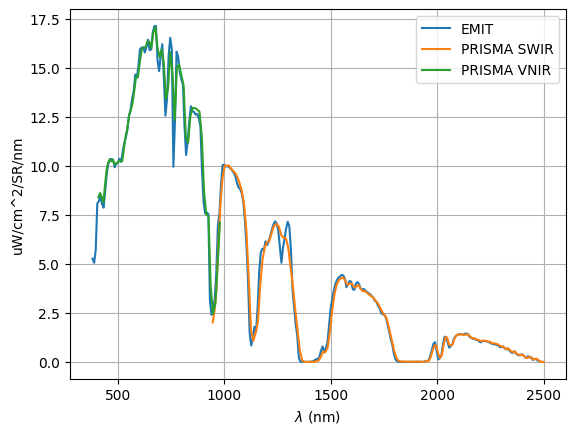

In [6]:
# Center pixel
pixel_value_emit = ei_on_point.values[:, 25, 25]

pixel_value_prisma = pi.ltoa_swir[pixel_prisma + (slice(None),)]
pixel_value_prisma_vnir = pi.ltoa_vnir[pixel_prisma + (slice(None),)]

plt.plot(ei.wavelengths, pixel_value_emit, label="EMIT")
plt.plot(pi.wavelength_swir[pixel_prisma[1],:], pixel_value_prisma/10, label="PRISMA SWIR")
plt.plot(pi.wavelength_vnir[pixel_prisma[1],:], pixel_value_prisma_vnir/10, label="PRISMA VNIR")

plt.ylabel(ei.units)
plt.xlabel("$\lambda$ (nm)")
plt.grid()
plt.legend()

## Load RGB reflectance

In [7]:
rgb_prisma = pi.load_rgb(raw=False)
rgb_prisma

 
         Transform: | 30.00, 0.00, 199694.39|
| 0.00,-30.00, 3501644.59|
| 0.00, 0.00, 1.00|
         Shape: (3, 1219, 1227)
         Resolution: (30.0, 30.0)
         Bounds: (199694.3906206509, 3465074.5888539106, 236504.3906206509, 3501644.5888539106)
         CRS: EPSG:32632
         fill_value_default: -1
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

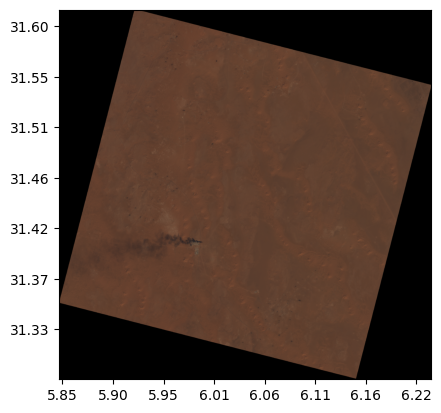

In [8]:
plot.show(rgb_prisma)

In [9]:
rgb_emit = ei.load_rgb(as_reflectance=True)
rgb_emit

 
         Transform: | 60.00, 0.00, 184463.99|
| 0.00,-60.00, 3571041.85|
| 0.00, 0.00, 1.00|
         Shape: (3, 1935, 2004)
         Resolution: (60.0, 60.0)
         Bounds: (184463.98930973688, 3454941.8506227555, 304703.9893097369, 3571041.8506227555)
         CRS: EPSG:32632
         fill_value_default: 0
        

<Axes: >

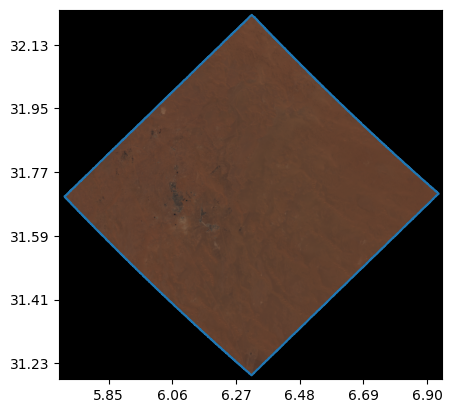

In [10]:
fig, ax = plt.subplots(1,1)
plot.show(rgb_emit, ax=ax)
plot.add_shape_to_plot(ei.footprint(crs="EPSG:4326"), crs_plot=ei.crs, crs_shape="EPSG:4326", polygon_no_fill=True, ax=ax)

## Plot RGB over the exact same area

In [11]:
import geopandas as gpd
metadata = gpd.GeoDataFrame({"geometry": [ei.footprint(crs="EPSG:4326"), pi.footprint(crs="EPSG:4326")],
                             # "geometry": [rgb_emit.valid_footprint(crs="EPSG:4326"), rgb_prisma.valid_footprint(crs="EPSG:4326")],
                             "satellite": ["EMIT", "PRISMA"],
                             "tile_date": [ei.time_coverage_start.isoformat(), pi.time_coverage_start.isoformat()]},
                            geometry="geometry",
                            crs="EPSG:4326")
metadata

,geometry,satellite,tile_date
0,"POLYGON ((6.29588 32.23147, 6.29591 32.23039, ...",EMIT,2023-09-29T12:25:34+00:00
1,"POLYGON ((5.84349 31.34925, 6.15325 31.28879, ...",PRISMA,2023-09-29T10:27:49.047000+00:00


In [12]:
metadata.explore()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: title={'center': 'PRISMA'}>

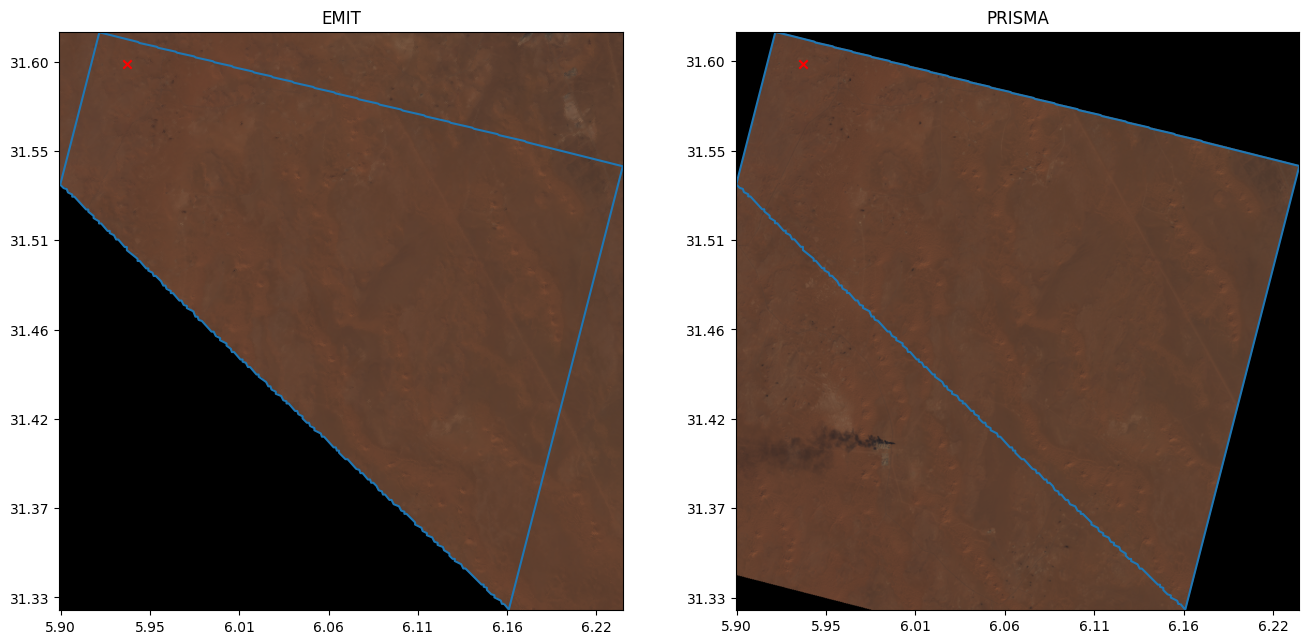

In [13]:
pol_intersection = rgb_emit.valid_footprint(crs="EPSG:4326").intersection(rgb_prisma.valid_footprint(crs="EPSG:4326"))

rgb_emit_intersect = read.read_from_polygon(rgb_emit, pol_intersection, "EPSG:4326")
rgb_prisma_intersect = read.read_from_polygon(rgb_prisma, pol_intersection, "EPSG:4326")

# Show point where we extracted the profile in the plot
point_prisma_epsg = Point(*point_prisma)
point_emit_crs = polygon_to_crs(point_prisma_epsg, crs_polygon="EPSG:4326", dst_crs=rgb_emit_intersect.crs)
point_prisma_crs = polygon_to_crs(point_prisma_epsg, crs_polygon="EPSG:4326", dst_crs=rgb_prisma_intersect.crs)

fig, ax = plt.subplots(1,2,figsize=(16,10))
plot.show(rgb_emit_intersect, ax=ax[0], title="EMIT")
ax[0].scatter([point_emit_crs.coords[0][0]], [point_emit_crs.coords[0][1]], marker="x", color="red")
plot.add_shape_to_plot(pol_intersection, crs_plot=rgb_emit_intersect.crs, crs_shape="EPSG:4326", polygon_no_fill=True, ax=ax[0])
plot.show(rgb_prisma_intersect, ax=ax[1], title="PRISMA")
ax[1].scatter([point_prisma_crs.coords[0][0]], [point_prisma_crs.coords[0][1]], marker="x", color="red")
plot.add_shape_to_plot(pol_intersection, crs_plot=rgb_prisma_intersect.crs, crs_shape="EPSG:4326", polygon_no_fill=True, ax=ax[1])

## Zoom in in the point

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


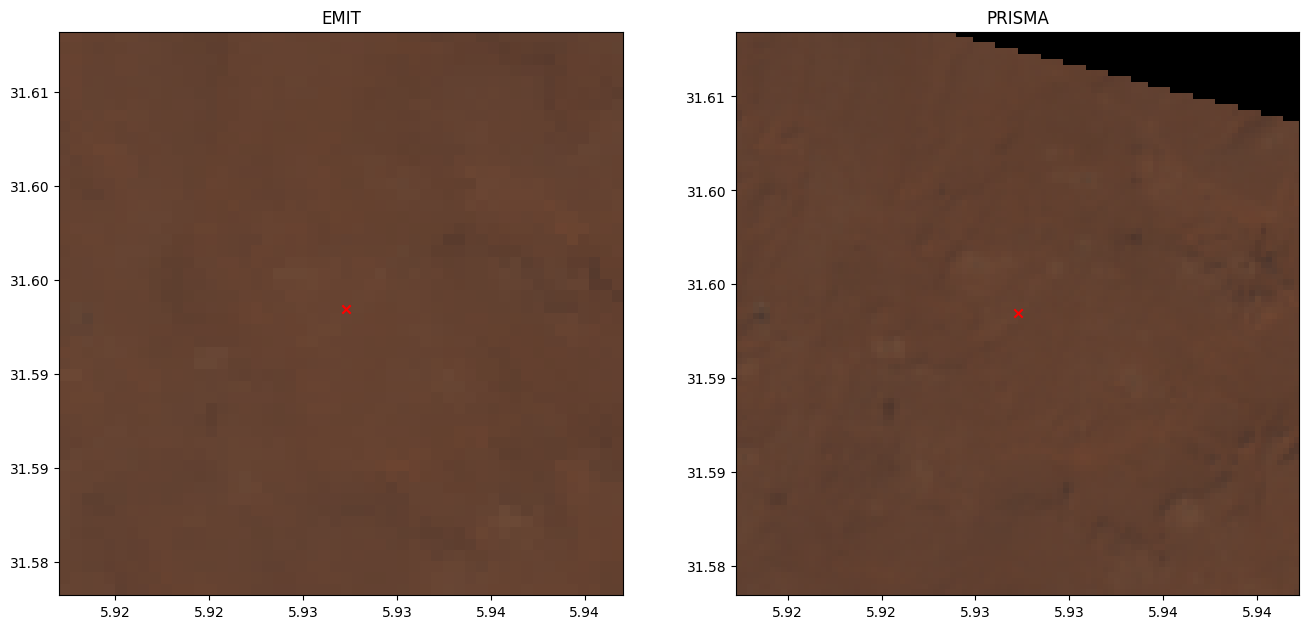

In [14]:
rgb_emit_point = read.read_from_center_coords(rgb_emit, point_prisma, shape=(50,50),
                                                  crs_center_coords="EPSG:4326")
rgb_prisma_point = read.read_from_center_coords(rgb_prisma, point_prisma, 
                                                shape=(100,100),
                                                crs_center_coords="EPSG:4326")

# # Show point where we extracted the profile in the plot
# point_prisma_epsg = Point(*point_prisma)
# point_emit_crs = polygon_to_crs(point_prisma_epsg, crs_polygon="EPSG:4326", dst_crs=rgb_emit_intersect.crs)
# point_prisma_crs = polygon_to_crs(point_prisma_epsg, crs_polygon="EPSG:4326", dst_crs=rgb_prisma_intersect.crs)

fig, ax = plt.subplots(1,2,figsize=(16,10))
plot.show(rgb_emit_point, ax=ax[0], title="EMIT")
ax[0].scatter([point_emit_crs.coords[0][0]], [point_emit_crs.coords[0][1]], marker="x", color="red")
plot.show(rgb_prisma_point, ax=ax[1], title="PRISMA")
ax[1].scatter([point_prisma_crs.coords[0][0]], [point_prisma_crs.coords[0][1]], marker="x", color="red")

## Licence
The georeader package is published under a [GNU Lesser GPL v3 licence](https://www.gnu.org/licenses/lgpl-3.0.en.html)

 If you find this work useful please cite:

```
@article{ruzicka_starcop_2023,
	title = {Semantic segmentation of methane plumes with hyperspectral machine learning models},
	volume = {13},
	issn = {2045-2322},
	url = {https://www.nature.com/articles/s41598-023-44918-6},
	doi = {10.1038/s41598-023-44918-6},
	number = {1},
	journal = {Scientific Reports},
	author = {Růžička, Vít and Mateo-Garcia, Gonzalo and Gómez-Chova, Luis and Vaughan, Anna, and Guanter, Luis and Markham, Andrew},
	month = nov,
	year = {2023},
	pages = {19999},
}
```